In [33]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import os
import pandas as pd

In [34]:
gen_dir = Path("saved_models/edm2_small_old/samples/tensors")
mcmc_dir = Path("mcmc_reference/results_noTe/normalized/data")
norm_file = Path("data/batch_3/normalized_all/norm_data.csv")

def denormalize(tensor, norm_file):
    normalization_info = pd.read_csv(norm_file)

    names = normalization_info["Field"].to_list()
    mean = normalization_info["Mean"].to_numpy()
    std = normalization_info["Std"].to_numpy()
    log = normalization_info["Log"].to_numpy()
    
    denorm = tensor * std[..., None] + mean[..., None]
    log_inds = np.where(log)
    denorm[:, log_inds, :] = np.exp(denorm[:, log_inds, :])
    return names, denorm

def load_samples(sample_dir, norm_file, num_samples = None):
    files = os.listdir(sample_dir)
    if num_samples is not None:
        files = np.random.choice(files, size=num_samples).tolist()

    data = [
        np.load(sample_dir/ x)["data"] for x in files
    ]

    return denormalize(data, norm_file)

N = 2**13
field_names, samples_generated = load_samples(gen_dir, norm_file)
_, samples_mcmc = load_samples(mcmc_dir, norm_file, num_samples = N)

In [35]:
QUANTILES = [0.025, 0.25, 0.5, 0.75, 0.975]

x = np.linspace(0, 3, samples_generated.shape[-1])

def plot_quantiles(ax, x, qs, color=None, zorder = 0):
    color = "tab:blue" if color is None else color
    alpha_95 = 0.25
    alpha_50 = 0.5

    linestyle_50 = "--"
    linestyle_95 = ":"

    line_95_lo = qs[0, :]
    line_50_lo = qs[1, :]
    line_med = qs[2, :]

    line_50_hi = qs[3, :]
    line_95_hi = qs[4, :]

    #ax.plot(x, line_95_lo, color=color, linestyle=linestyle_95)
    #ax.plot(x, line_95_hi, color=color, linestyle=linestyle_95)
    #ax.plot(x, line_50_lo, color=color, linestyle=linestyle_50)
    #ax.plot(x, line_50_hi, color=color, linestyle=linestyle_50)
    ax.plot(x, line_med, color=color, zorder=zorder+2)

    ax.fill_between(x, line_50_lo, line_50_hi, color=color, alpha=alpha_50, linewidth=0, zorder=zorder+1)
    ax.fill_between(x, line_95_lo, line_50_lo, color=color, alpha=alpha_95, linewidth=0, zorder=zorder)
    ax.fill_between(x, line_50_hi, line_95_hi, color=color, alpha=alpha_95, linewidth=0, zorder=zorder+1)



In [36]:
field_info = {
    "Tev": dict(
        ylabel = r"Electron temperature (eV)",
    ),
    "inv_hall": dict(
        ylabel = r"$\nu_{an}/\omega_{ce}$",
        ylog = True,
    ),
    "ne": dict(
        ylabel = r"Plasma density (m$^{-3}$)",
        ylog = True,
    ),
    "ui_1": dict(
        ylabel = r"Ion velocity (km/s)",
        yscalefactor = 1/1000,
    ),
    "E": dict(
        ylabel = r"Electric field (kV/m)",
        yscalefactor = 1/1000,
    ),
    "phi": dict(
        ylabel = r"Potential (V)",
    ),
    "nn": dict(
        ylabel = r"Neutral density (m$^{-3}$)",
        ylog = True,
    ),
}

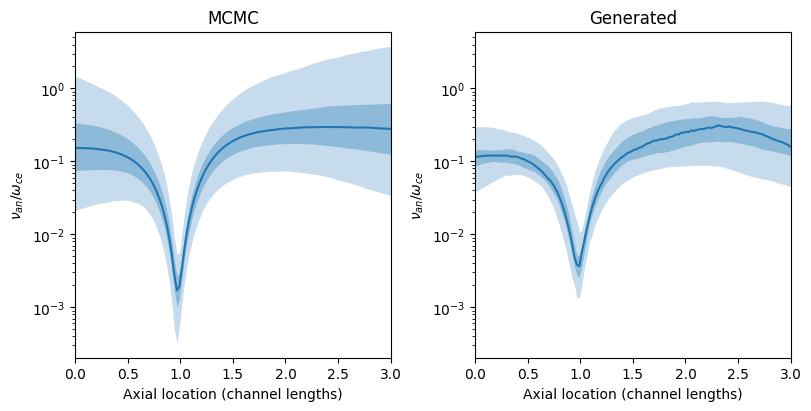

In [37]:
def plot_field(ax, x, data, ylabel, ylog = False, yscalefactor=1.0, xlabel = None, color = "tab:blue", zorder=0):
    if xlabel is None:
        xlabel = "Axial location (channel lengths)"

    ax.set(xlabel=xlabel, ylabel=ylabel, yscale='log' if ylog else 'linear', xlim=(x[0], x[-1]))

    qs = np.quantile(data, QUANTILES, axis=0) * yscalefactor
    assert qs.shape == (len(QUANTILES), data.shape[1])

    plot_quantiles(ax, x, qs, color=color, zorder=zorder)

def get_field(field, field_names, data):
    index_dict = {n: i for (i, n) in enumerate(field_names)}

    if field == "inv_hall":
        q_e = 1.6e-19
        m_e = 9.1e-31
        nu_an = data[:, index_dict["nu_an"], :]
        w_ce = data[:, index_dict["B"], :] * q_e / m_e
        return nu_an / w_ce
    else:
        return data[:, index_dict[field], :]

field = "inv_hall"

fig, axes = plt.subplots(1,2, layout = 'constrained', figsize=(8,4))
field_gen = get_field(field, field_names, samples_generated)
field_mcmc = get_field(field, field_names, samples_mcmc)

plot_field(axes[0], x, field_mcmc, **field_info[field])
plot_field(axes[1], x, field_gen, **field_info[field])

titles = ["MCMC", "Generated"]
ymin = min(ax.get_ylim()[0] for ax in axes)
ymax = max(ax.get_ylim()[1] for ax in axes)
for (i, ax) in enumerate(axes):
    ax.set_ylim(ymin, ymax)
    ax.set_title(titles[i])

plt.show()


In [38]:
field_names

['B',
 'nu_e',
 'nu_an',
 'nn',
 'ne',
 'ni_1',
 'ni_2',
 'ni_3',
 'ui_1',
 'ui_2',
 'ui_3',
 'ue',
 'phi',
 'E',
 'Tev',
 'pe',
 '∇pe']